In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [51]:
Image('wheel_encoders.png')

In a differential-drive model, we discussed the relation between wheel velocities and robot's rotational and translational velocity, i.e, $v, \omega$. 

If we need to know curent $v, \omega$ how to measure wheel velocities? We use wheel encoders

Encoder resolution = $N$

Every $\Delta T$ ms,
+ Encoder reports # ticks wheel moved = $n$
+ Angle moved = $2\pi \frac{n}{N}$

Usage
+ Smallest movement that can be measured is $\frac{2\pi}{N}$
+ Largest speed that can be measured is $\frac{2\pi}{\Delta T}$

Pros:
+ Fairly accurate estimates of linear/ angular velocity
+ Distances and rotations are accurate in short-term

Cons:
+ Vehicle position “drifts” when $v,\omega$ is integrated over longer periods

Say, your robot's initial pose is (0.0, 0.0, 0.0), write a program to accept left and right ticks as input and output the next pose

Assume an unicycle model and following vehicle parameters
+ Wheel radius ($r$) =  2.0m
+ Track-width ($L$) = 4.0m
+ Encoder ticks ($N$) = 100 
+ Encoder frequency ($\Delta T$) = 0.1

Test your code with $n_{right} = 10$ and $N_{left} = 6$. Do you get the next pose as $(1.0053, 0.0, 0.1257)$?

In [14]:
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += w*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    # return calculated (x, y, theta)
    return x, y, theta

In [10]:
r = 2
L = 4
N = 100
dt = 0.1
nr = 10
nl = 6
w = (r / L) * 2 * np.pi * (nr - nl) / (N * dt)
v = (r / 2) * 2 * np.pi * (nr + nl) / (N * dt)
pose = (0, 0, 0)
pose = unicycle_model(pose, v, w, dt)
print(pose)


(1.0053096491487339, 0.0, 0.12566370614359174)


### Effect of angular error in pose estimate

In [22]:
initial_error = np.deg2rad(5.0)
robot_pose = np.array([0, 0, np.pi/2 + initial_error])

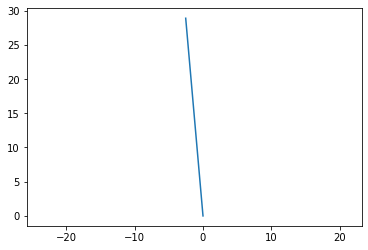

In [23]:
# write your code to simulate straight line motion 
# robot can be assumed to be moving at constant speed of 2 m/s for 30 seconds
# feel free to borrow code from your previous notebooks
def straight_line_motion(initial_error):
  robot_pose = np.array([0, 0, np.pi/2 + initial_error])
  v = 2
  t = 30
  robot_trajectory=[]
  all_v = np.ones(t)
  all_w = np.zeros(t)
  for v, w in zip(all_v, all_w): 
    robot_trajectory.append(robot_pose)
    robot_pose=unicycle_model(robot_pose,v,w)
  robot_trajectory=np.array(robot_trajectory)
  return robot_trajectory  

robot_trajectory = straight_line_motion(initial_error)
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])

# print(60 * np.tan(np.deg2rad(2)))

If there was no initial angle error, robot will end up at $x$ = 0.0. 

Plot a graph between initial_error and final $x$ position?

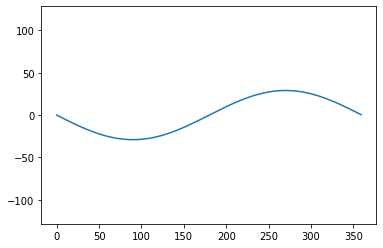

In [27]:
initial_error = [np.deg2rad(i) for i in range(0,360)]
df = []
for i in range(len(initial_error)):
  robot_trajectory = straight_line_motion(initial_error[i])
  df.append([i, robot_trajectory[-1][0]])
df = np.array(df)
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(df[:,0], df[:,1])


### Demonstrate localization drift in wheel encoders

### Synthetic dataset

In [15]:
all_v = np.ones(100)
all_w = np.zeros(100) 

In [16]:
robot_traj, robot_traj_noisy = [], []
ideal_pose = np.array([0, 0, np.pi/2])
noisy_pose = np.array([0, 0, np.pi/2])
robot_traj.append(ideal_pose)
robot_traj_noisy.append(noisy_pose)
for v, w in zip(all_v, all_w):
    #code to update ideal_pose
    #ideal_pose = 
    ideal_pose = unicycle_model(ideal_pose,v,w)
    #code to update noisy pose
    #add gaussian noise with std dev of 0.01 to omega
    #noisy_pose = 
    noisy_pose = unicycle_model(noisy_pose, v , w + np.random.normal(0,0.01))
    robot_traj.append(ideal_pose)
    robot_traj_noisy.append(noisy_pose) 
robot_traj = np.array(robot_traj)
robot_traj_noisy = np.array(robot_traj_noisy)

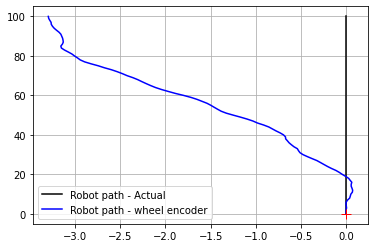

In [18]:
plt.figure()
plt.grid()
# plt.axes().set_aspect("equal","datalim")
plt.plot(robot_traj[:,0], robot_traj[:,1],'k-', label='Robot path - Actual')
plt.plot(robot_traj_noisy[:,0], robot_traj_noisy[:,1],'b-', label='Robot path - wheel encoder')
plt.plot(0, 0, 'r+', ms=10)
plt.legend()

### Real dataset

In [7]:
from google.colab import files
uploaded = files.upload()

Saving ground_truth.csv to ground_truth.csv


In [9]:
from google.colab import files
uploaded = files.upload()

Saving wheel_control.csv to wheel_control.csv


In [19]:
!ls

ground_truth.csv  sample_data  wheel_control.csv


In [25]:
data_dir = "."
ground_truth = pd.read_csv(data_dir + "/ground_truth.csv")
gt_traj = np.array(ground_truth[['x','y']])
wheel_enc = np.array(pd.read_csv(data_dir + "/wheel_control.csv")[['v','w']])

In [26]:
def unicycle_model(pose, v, w, dt = 0.01):
  x, y, theta = pose
  x += v*np.cos(theta)*dt
  y += v*np.sin(theta)*dt
  theta += w*dt
  theta = np.arctan2(np.sin(theta), np.cos(theta))
  return x, y, theta

In [27]:
pose = np.array(ground_truth[['x','y','theta']])[0] #initial pose
robot_traj = []
robot_traj.append(pose)
for v, w in wheel_enc:
    # code for updating pose
    pose = unicycle_model(pose, v, w)
    robot_traj.append(pose)
robot_traj = np.array(robot_traj)

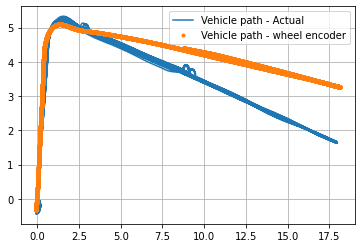

In [28]:
end = 10000
plt.figure()
plt.grid()
plt.plot(gt_traj[:,0], gt_traj[:,1], label='Vehicle path - Actual')
plt.plot(robot_traj[:end,0], robot_traj[:end,1], '.', label='Vehicle path - wheel encoder')
plt.legend()